# Transformer, Self-Attention и моделирование языка

Если все пересчитывать, это (2.5 + 12+) часов

In [1]:
QUICK_RUN = True

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, \
    save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
    GreedyGenerator, BeamGenerator
from dlnlputils.pipeline import train_eval_loop, init_random_seed
from dlnlputils.base import get_params_number

init_random_seed()

## Загрузка текстов и разбиение на обучающую и тестовую подвыборки

При загрузке текста мы читаем весь его в память, а потом нарезаем на кусочки размером в 200 символов. Таким образом мы получим набор небольших фрагментов текста, но, при этом, длина каждого фрагмента будет больше, чем длина отдельного предложения. 

Современные языковые модели работают с более длинными последовательностями, поэтому общепринятая схема — это "не выполнять разбиение текста на отдельные предложения перед подачей их в языковую модель". 

In [4]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
all_chunks = load_war_and_piece_chunks('./datasets/war_and_peace.txt')
len(all_chunks)

7976

- пример фрагмента

In [5]:
print(all_chunks[10])

у нее был грипп, как она говорила (грипп был тогда новое
слово, употреблявшееся только редкими). В записочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez


- обучающая и тестовая выборки 70/30

In [6]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 5583
Размер валидационной выборки 2393


## Токенизация корпуса с помощью BPE

BPE - Byte Pair Encoding

- Современные языковые модели работают, как правило, не с целыми токенами. Они работают с фрагментами слов, или, так называемыми "sub-word units" (по сути, это N-граммы символов). 
- Поэтому для токенизации мы используем не классический токенизатор с помощью регулярных выражений или каких-то других правил (например, как те которые мы использовали в предыдущих семинарах). Здесь мы используем алгоритм "byte pair encoding".
- Такой алгоритм позволяет получить нечто среднее между алгоритмами, работающими на уровне отдельных токенов, и на уровне отдельных символов. 
- Когда мы работаем с отдельными символами, у нас алфавит маленький, то есть решать задачу классификации нам попроще, но длина последовательностей растёт и поэтому нам нужно строить модели, которые умеют запоминать далёкие зависимости. Это достаточно сложно. 
- Наоборот, если мы работаем с отдельными токенами, то последовательности у нас гораздо короче. Но, с другой стороны, словарь у нас разрастается очень быстро (нам нужно уметь предсказывать каждый отдельный токен, а токенов очень много — гораздо больше, чем символов). 

**YouTokenToMe - быстрая реализация BPE** 
- разработка ВКонтакте, 
- написана на плюсах с бустом
- является **самой быстрой** реализацией byte pair encoding (в основном, за счет умной многопоточности, но и алгоритмическая ассимптотика тоже, извините, $O(N)$). **Короче, красаучики**! 
- к питону биндинги + cli
  - поэтому работает через файлы, а не объекты питона

In [7]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
BPE_MODEL_FILENAME = './models/war_and_peace_bpe.yttm'

- `save_texts_to_file` просто собирает в один файл тренировочные нарезки исходного текста
- `train` берет обучающий файл, считает счетчики, строит словарь замен, короче обучается, и складывает это все в файл `model`

Ключевой параметр `vocab_size`:
- определяет, что мы получим, более длинные последовательности, но меньший словарь, или более короткие последовательности, но более крупный словарь
- чем больше словарь, тем больше будет редких классов — это будет создавать нам некоторые сложности при обучении

In [8]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
TRAIN_TEXTS_FILENAME = './datasets/war_and_peace_bpe_train.txt'
save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);

Training parameters
  input: ./datasets/war_and_peace_bpe_train.txt
  model: ./models/war_and_peace_bpe.yttm
  vocab_size: 1000
  n_threads: 4
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 142
number of deleted characters: 0
number of unique characters left: 142
model saved to: ./models/war_and_peace_bpe.yttm


Когда модель обучена, мы создаём экземпляр класса "bpe" и передаём туда путь к файлу с обученной моделью

In [9]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

Фактически BPE решает задачу "Пожалуйста, выдели нам 1000 наиболее характерных N-грамм через byte pair encoding". Вот же они:
- служебные токены  (заполнитель, начало/конец строки)
- включает все символы
- наиболее частые биграммы, триграммы
- дальше в 1000 токенов попали также имена собственные (▁Пьера ▁Ростов и т.д.) - это скорее всего не есть хорошо, и явно слишком специфические последовательности:
  - Скорее всего, это сигнал к тому, что можно сделать словарь поменьше для нашей модели. Но это не так очевидно, нужно смотреть на метрики на отложенной выборке, чтобы выбрать правильный размер словаря. 

In [10]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з б . ч й - ж ш e х ю s ц a n r i u o t щ э П l Н ф А В m d c О ? ! К Д Б p М v Р " ) С ( ' ; И Т ё 1 h : Я 2 q f Г ъ b g Ч Э 0 3 Е 5 ] [ j 4 I z Л З 6 8 M A 9 7 У Ж V L x X Ф Ш y C Х J B P D E N S k Ц R Q O T ` w Ю H U F G K Ь W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ру ет ▁ко ▁бы ми ны ня да ▁то ди хо ▁за ▁го ем ▁г ▁он ол ени ▁от ки ви ну каз е, ▁э та ▁П ти ши ▁при ▁вы ▁ра му ▁Н ▁ж ов ▁вс ле ▁А до ▁В ▁про ▁мо ля ▁как мо ▁во казал ры ▁его ма ▁об сто ▁это ль й, ▁сказал ере не ▁а ▁до ▁О ▁я ▁К ▁кото ▁сво ▁кня ▁Д м, у, ше ▁Б али по чи ▁но сти ▁ни си ча ста ель ▁из ве лу ала де ▁Ан вори ▁М ▁под ▁ка ▁d .. ша ... за ска жи ще es я, лся ▁со че лы зь сть ско ou ▁ли ▁хо ▁ви ▁ст ень ▁ру ря енно ▁Пь ▁так ме ты ▁p ▁Р ги га дел лю сно re же ▁раз ▁( со те ду ку ▁се ски ▁c ▁С ▁ва вши ▁все тель бе en вал ▁l ▁дру ▁было ▁И on

Токенизирует пакетами (спасибо кэп)

In [11]:
enc = tokenizer.encode(train_texts[:2])
print(enc)
print(tokenizer.decode(enc))

[[210, 238, 244, 13, 317, 16, 147, 200, 12, 265, 35, 161, 337, 490, 203, 269, 447, 4, 111, 111, 96, 27, 415, 148, 176, 551, 201, 726, 199, 161, 848, 889, 772, 23, 16, 690, 179, 585, 18, 154, 412, 19, 382, 157, 186, 635, 10, 518, 774, 363, 670, 157, 793, 37, 7, 426, 791, 186, 635, 10, 518, 774, 650, 25, 988, 206, 186, 13, 201, 8, 149, 474, 17, 275, 31, 23, 8, 34, 444], [623, 274, 337, 317, 177, 743, 251, 217, 169, 569, 905, 573, 165, 293, 267, 439, 149, 200, 260, 623, 274, 337, 317, 177, 871, 277, 263, 19, 15, 11, 22, 7, 14, 17, 162, 381, 662, 161, 669, 394, 409, 13, 220, 9, 158, 186, 570, 793, 195, 384, 801, 175, 220, 18, 934, 23, 187, 169, 447, 281, 24, 363, 11, 229, 327, 205, 216, 348, 512, 273, 147, 422, 418, 216, 9, 164, 316]]
['от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш', 'чтобы избегать или атаковать неприятеля, но только в том, чтобы избегать генер

In [12]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

Посмотрим как оно:
- исходные тексты были ровно по 200 символов
- закодированные причудливо распределились в [60, 140] токенов
  - мода примерно 80 (последовательности ужались более чем в 2 раза)

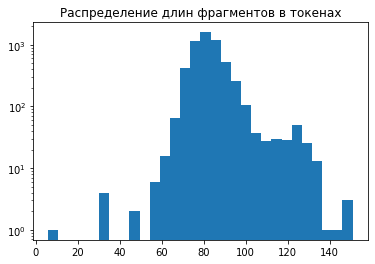

In [13]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

Частотность новых BPE-токенов - похожа на распределение Ципфа, значит все ОК

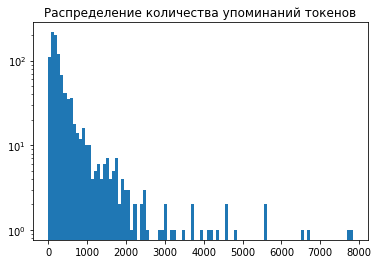

In [14]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

А вдруг в тестовой выборке окажутся токены, которых нет в обучающей выборке?
- нет, таких не оказалось
- **может быть**, какие-то длинные N-граммы мы там не нашли
- **зато** мы смогли эти длинные N-граммы разбить на более мелкие
- **всё равно**, все символы у нас так или иначе нашлись в словаре

Таким образом, когда у нас в новом тексте встречаются только неизвестные слова, то BPE просто деградирует до character-level, то есть наша модель просто становится моделью на уровне отдельных символов. Это, конечно, посложнее, но она не перестаёт работать.

Т.е. даже если и на уровне символов появятся неизвестные токены, то токенизатор при декодировании их заменит на спецсимвол `<UNK>`, так что никакого криминала

In [15]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


## Подготовка датасетов для PyTorch

- `LanguageModelDataset` принимает список токенизированных предложений, выдает данные по индексу
  - выбирает случайный фрагмент заданной длины
  - выдает двумя переменными: все кроме последнего токена (вход модели), все кроме первого токена (таргет)
    - т.о. токен `target[i]` модель должна научиться предсказывать по фрагменту `chunk[:i-1]`
    - *надо ли так размножать фрагменты, если это просто сдвиг на 1 токен?*

In [16]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

In [17]:
train_dataset[0]

(array([  2, 210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161,
        337, 490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176,
        551, 201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,
         18, 154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670,
        157, 793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25,
        988, 206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,
         34, 444]),
 array([210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161, 337,
        490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176, 551,
        201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,  18,
        154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670, 157,
        793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25, 988,
        206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,  34,
        444,   3]))

In [18]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш',
 'от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш<EOS>']

## Общие классы и функции

### Маска зависимостей

Казалось бы, если подать модели на вход такой фрагмент и целевым поставить его же, сдвинутый на 1 токен, то линейный классификатор это сразу "заметит" и просто так и будет по входу предсказывать сдвинутый на 1 выход.

Нужно, что бы при получении такого входа модель "не знала" ничего, о том, что у целевого вектора правее i-й координаты. Для этого используется **маска зависимости позиции**:
- строка - номер позиции в выходе
- столбец - номер позиции во входе
- 0, если токен можно использовать в прогнозировании
- так в механизме внимания зануляются элементы, которые не должны учитываться в расчете релевантности

In [19]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

print(make_target_dependency_mask(10))

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


### Кодирование позиции

Механизм self-attention — он, в некотором смысле, похож на механизм свёрток, тем, что он инвариантен к позиции элемента в последовательности (за одну операцию все элементы сравниваются со всеми).

Даже если порядок слов и не фиксированный, то относительные позиции токенов уж точно полезны. При этом случай, когда связь между словами идёт через пол-текста, достаточно редкий (даже для человека такие связи бывают слишком сложными для улавливания смысла).

Для того, чтобы закодировать позиции токенов, к эмбеддингу токена, который мы берём из таблички, будем прибавлять **эмбеддинг позиции** - вектор такой же длины, что и эмбеддинг токена, который имеет разное значение для разных позиций этого токена в последовательности (тексте).

Авторы трансформера предлагают использовать набор синусоид и косинусоид разной частоты.
- так обеспечивается равноудаленность друг от друга векторов позиции по метрике косинусного расстояния
- при этом при увеличении количества таких векторов не потребуется увеличивать размерность кодирующего вектора или типа того, просто берутся более высокочастотные гармоники (из количество EmbSize // 2)

In [20]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

Один вертикальный срез графика описывает нам эмбеддинг одной позиции. Тут:
- последовательность длины 30 (такая частота дискретизации (удвоенная, т.к. синусы и косинусы))
- длина эмбеддинга 30 (такое количество гармоник)

Выдает матрицу $Len \times EmbSize$

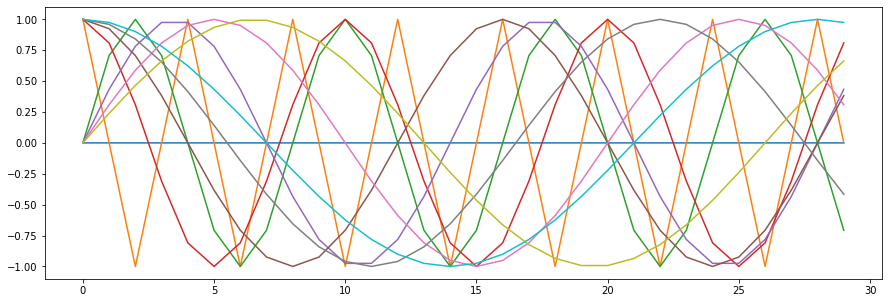

In [21]:
sample_pos_codes = make_positional_encoding(30, 30)     # не умеет с нечетной размерностью ебмеддинга (!)
plt.plot(sample_pos_codes[:, ::3].numpy());             # нарисует только каждую 3ю гармонику
plt.gcf().set_size_inches((15, 5))

### Основной класс - языковая модель

Определен базовый класс:
- хранение векторов слов
- получение кодов позиций
- предсказание токенов для каждой позиции

`forward`:
- по длине последовательности мы можем сгенерировать маску зависимостей
- еще одна маска для паддинга (отмечает токены за границей последовательности), если входящая последовательность короче максимальной длины
- получаем эмбеддинги из встроенного модуля (по сути случайные из ст.норм.распределения)
  - `padding_idx=0` говорит, что нулевой токен - фиктивный для паддинга
- получаем позиционные эмбеддинги (они из синокосинусов, поэтому из [-1, 1], что хоть и не нормировано с основным эмбеддингом, но сопоставимо и проблем не доставит (?))
- делаем дропаут, отбрасываем случаные токены из последовательности
  - если не делать, модель будет переобучаться, просто запоминать входящий текст
  - если слишком большой - ничему не научится
  - какой дропаут важнее, этот или опционально используемый в основной нейросети?
    - кажется этот для улавливания смысла важнее, тот для сходимости вроде большей частью?
- подаем признаки токенов с масками зависимостей и паддинга в некоторую нейросеть, которая здесь у нас лежит в переменной `backbone`
  - должна возвращать тензор той же размерности, что и получила
  - нейросеть вообще говоря выдет значения $\in \R$), то что она выдала считаем признаками/предикторами/регрессорами соответствующих целевых токенов
- чтобы эти признаки перевести в вероятности используется выходной полносвязный слой (простой линейный слой `nn.Linear`), который выдает то, что считаем [логитами](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F)
  -  он так устроен, что если получает многомерный тензор, то линейная проекция применяется к последнему измерению

In [22]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length) \
            .to(seed_token_ids.device)
        
        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length,
                                             self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = seed_embs
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

Чтобы получить распределение вероятностей из логитов, полученных на выходе модели, нам нужно применить к этому тензору softmax по последнему измерению ('мягко' нормировать к [0, 1]):
- мы не будем это делать, потому что мы знаем, что после логитов сразу пойдёт [кросс-энтропия](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D1%91%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F) как вычисление функции потерь
- поэтому [софтмакс](https://ru.wikipedia.org/wiki/Softmax) на выходе можно не считать, т.к. лишние экспоненты и логарифмы сократятся, и получить большую вычислительную стабильность

### Утилиты для обучения - функция потерь и расписание изменения длины градиентного шага

Фунция потерь - кросс-энтропия:
- тут нам уже не важны обучающие пакеты/батчи, по этим измерениям все вытягивается 
- `F.cross_entropy` умеет игнорировать паддинги (!) - это выровняет дисбаланс классов (токены) и улучшит сходимость

Расписание изменения шага:
- половинит шаг, если за 20 эпох функция потерь не уменьшилась

In [23]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

### Еще полезные штуки

- Таблица параметров модели. Типа подробный `get_parameters()` 
- Все тензоры ноутбука
- Очистить память от ненужных тензоров/моделей

In [ ]:
from helpers.summary import count_parameters, dump_tensors, free_mem

## Реализация Transformer из PyTorch
Появилась в версии торча 1.2

Мы будем использовать не весь трансформер, а только его первую часть — трансформер "encoder". Этот вспомогательный класс нам нужен для двух задач. По какой-то причине, стандартная реализация трансформера умеет работать с тензорами, в которых первое измерение соответствует не размеру батча, а длине последовательности, а "batch_size" стоит на втором месте. 

Этот класс делает, по сути, всего лишь две вещи. 

1. Транспонирует тензор перед подачей в трансформер, транспонирует результаты работы трансформера обратно, и возвращает результат не изменённым **(возможно уже не актуально)**. 
2. Инициализирует параметры. По умолчанию, в трансформере используется равномерный шум с амплитудой, подбираемой исходя из количества входных признаков. Эта схема инициализации реализовывается в pytorch функцией `xavier_uniform`. Таким способом, мы инициализируем все веса, кроме bias, то есть все "матричные" веса. 

In [27]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

В конструктор модели передается:
- размер словаря, размер эмбеддинга
- экземпляр backbone НС
  - будет производить агрегацию контекстов, 
  - будет сравнивать слова с соседними словами 
  - на вход она будет получать эмбеддинги отдельных токенов, 
  - на выходе у неё уже будут эмбеддинги фраз, предложений
- используется 3 слоя механизма внимания

In [28]:
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256,
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
count_parameters(torch_transf_model, verbose=False)

Total Trainable Params: 2094312
Total memory: 175.76 Mb


2094312

- размер батча 128, подбирается по объему памяти GPU
- большое количество эпох
  - количество пройденных эпох Х количество итераций в эпохе = количество градиентных шагов
  - сходится медленно
- 613 эпох Х 44 итерации Х ~11 сек. = 2,5 часа (GF760gtx):
  - train loss = 1.210
  - test loss = 2.638

Сохранение:
- часто бывает полезно сохранять промежуточные результаты
  - чтобы можно было прервать/возобновить обучение
  - чтобы можно было усреднить модели с различных шагов (градиент встанет в промежуточное положение и может дальше двинуться куда-то еще)

In [29]:
SKIP = QUICK_RUN # (!) обучалка на 2.5 часа

if SKIP:
    torch_transf_model.load_state_dict(torch.load('./models/war_and_peace_torch_transf_best.pth'))
else:
    (best_val_loss,
    best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                                train_dataset,
                                                test_dataset,
                                                lm_cross_entropy,
                                                lr=2e-3,
                                                epoch_n=2000,
                                                batch_size=128,
                                                device='cuda',
                                                early_stopping_patience=50,
                                                max_batches_per_epoch_train=1000,
                                                max_batches_per_epoch_val=1000,
                                                lr_scheduler_ctor=lr_scheduler)
    
    torch.save(best_torch_transf_model.state_dict(), './models/war_and_peace_torch_transf_best.pth')

## Генерация текста с помощью языковой модели

### Жадная генерация

Алгоритм жадной генерации - это когда мы на каждом шаге берём наиболее вероятный токен **без учёта совместного распределения** токенов (то есть — вот на этом шаге модель сказала, что токен "А" самый лучший — мы его и берём вне зависимости от того, какой следующий токен может быть, или предыдущий).

Это полностью жадный алгоритм декодирования. Алгоритм:
- в конструктор обученную модель и "tokenizer"
- на вход затравку текста -> токенизация -> цикл:
  - прогон вектора через модель
  - выбор токена с максимальной оценкой
  - если токен конца текста, то всё
  - если нет, добавить к ранее срегенированному и опять на вход модели

In [30]:
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer)

Генерация занимает 360мс - это много (хотя у авторов получилось почему-то  и вовсе 1450мс)
- где засада?
  - мы много раз прогоняем увеличивающуюся последовательность через модель, но меняется только активация последнего слоя, остальные пересчитываются впустую
  - надо кешировать (может тут автоматом уже кешируется, почему у меня в 5 раз быстрее чем у авторов?), звучит просто, но есть тонкости как это грамотно сделать, с учетом расчета на gpu, поэтому как нибудь в другой раз

In [31]:
%%time

print(greedy_generator('сказала княжна, оглядывая Бона'))

сказала княжна, оглядывая Бонапарте в Шенбруне, который наш прием кровативную, на дороге и я имение, - прибавил он с у
CPU times: user 402 ms, sys: 29.5 ms, total: 431 ms
Wall time: 362 ms


In [32]:
print(greedy_generator('смеялась княжна, оглядывая Наполе'))

смеялась княжна, оглядывая Наполеования. - Je suis bavau mon comment dans les femes comme il fautes du


In [33]:
print(greedy_generator('сказала княжна, оглядывая Кутуз'))

сказала княжна, оглядывая Кутузя проводила его. Только глаза и с сильничами, чтобы не сдвиже, как вместе халатать. Также съезжающи


In [34]:
print(greedy_generator('сказал Кутузов, оглядывая Наполеона'))

сказал Кутузов, оглядывая Наполеона с восторгом, с тем же толпой шутеля и набоном не будете. Большим тот сели в знакомые;


Жадный поиск не гарантирует обнаружения оптимального решения: возможно, выбрав менее вероятную букву сейчас, на следующем шаге мы сможем сделать выбор так, что результирующая вероятность нежадного варианта будет выше

При жадном поиске мы можем сгенерировать токен конца предложения слишком рано, никак это исправить уже не получится

### Генерация с помощью лучевого поиска - Beam Search

Более практичный вариант генератора - [**лучевой поиск**](https://en.wikipedia.org/wiki/Beam_search)

Параметры:
- `max_steps_n` наибольшее количество токенов, которые мы можем добавить к исходной последовательности, 
- `return_hypotheses_n` количество лучших гипотез, лучших вариантов декодирования, которое нам нужно вернуть, 
- `beamsize` (ширина луча) количество наилучших промежуточных вариантов, которое мы будем хранить в процессе.

Алгоритм:
- токенизация затравки текста
- `partial_hypotheses` промежуточные гипотезы - кортежи (оценка правдоподобия, гипотеза - последовательность токенов)
  - поддерживается в виде **очереди с приоритетами (куча)** `heapq` (встроенная реализация мин-кучи), чтобы наверху была лучшая гипотеза
  - инициализируется токенизированной затравкой текста

- в цикле (пока минкуча не пуста):
  - лучшая гипотеза извлекается из кучи и отправляется в модель
  - модель дает логиты (некоторые вещественные признаки токенов гипотезы), берем последний прогнозный
  - в логарифмический софтмакс - дает логарифмы вероятности (чтобы можно было складывать, вместо умножения)
  - из них выбираем `beamsize` наиболее вероятных прогнозных токенов, по ним еще один цикл:
    - во первых полученные лог-вероятности и токены копируются на хост (`float(),` `int()`)и этот цикл дальше считается на хосте, чтоб не утекала память gpu
    - оценка правдоподобности полученной гипотезы оценивается по нормализованной форме: $\log(t_1, ..., t_n) / \sqrt {n}$, чтобы не завышать оценки для коротких гипотез (более короткие гипотезы более вероятны):
      - $\sqrt n$ получается по идее из предположения, что длинные гипотезы имеют дисперсию оценки пропорциональную $n$?
    - формируется новая гипотеза: (пересчитанная с учетом удленнения последовательности оценка нормированной лог-вероятности, последовательность с новым токеном):
      - тут фишка пересчета в том, что лог-вероятности - отрицательные, и чем меньше, тем меньше вероятность, поэтому они вычитаются из предыдущей оценки, т.е. получается прибавляются, чем больше по модулю прибавилось, тем меньше вероятность, и тем ниже гипотеза уйдет в мин-куче. Вроде как такого рода переменные принято обзывать наподобие `token_logproba`, а не как тут
    - если заданная длина достигнута или токен конца предложения, то гипотеза идет в список финальных гипотез, иначе - добавляется в кучу
  
  - полученная куча обрезается по размеру `beamsize` (когда все гипотезы дойдут до заданной длины или конца предложения - куча опустеет)
- финальные гипотезы декодируются и возвращается столько наилучших вариантов, сколько запросили


Если `beamsize == 1` то лучевой поиск превращается в полностью жадный алгоритм.

[1] Тема жадного декодирования и лучевого поиска также будет рассматриваться позднее в [лекции про seq2seq](https://stepik.org/lesson/247980/step/5?unit=220092)

In [35]:
beam_generator = BeamGenerator(torch_transf_model, tokenizer)

Кхм, по времени 5 вариантов генерилось 1420мс, гдето 280мс на вариант, что быстрее жадного алгоритма (360мс). А у авторов наоборот, скорость лучевого поиска хуже оказалась, и в абсолютных значениях (8000мс). Также говорят, что не хватает кеширования...
- варианты так себе, очень похожие, разнообразия никакого

In [36]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.7414446024838184
сказала княжна, оглядывая Наполеона. - Ce nous savez, mon cher, Prince qu'il n'autre, 143 - проговорил

****
2.944877257567304
сказала княжна, оглядывая Наполеона. - Ce nous savez, mon cher, Prince qu'il n'autre, 143 - проговорила

****
2.9729833270923742
сказала княжна, оглядывая Наполеона. - Ce nous savez, mon cher, Prince qu'il n'autre, 14 - заговорила она

****
2.9998533507228093
сказала княжна, оглядывая Наполеона. - Ce nous savez, mon cher, Prince qu'il n'autre, 14 - заговорил солда

****
3.0248982640840683
сказала княжна, оглядывая Наполеона. - Ce nous savez, mon cher, Prince qu'il n'autre, 14 - заговорила княж

CPU times: user 1.59 s, sys: 32.8 ms, total: 1.62 s
Wall time: 1.25 s


In [37]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=20,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.4604581527427896
сказала княжна, оглядывая Наполеоном совершенно спрятала. - Mais, mon ami, mon ami.15 - C'est bien... 184 -

****
2.6130057235461708
сказала княжна, оглядывая Наполеоном совершенно спрятала. - Mais, mon ami, mon ami.15 - C'est beautien 1

****
2.6375666559038007
сказала княжна, оглядывая Наполеоном совершенно спрятала. - Ilsez, que je ne souverai pas voulu l'otrem

****
2.660364099154319
сказала княжна, оглядывая Наполеоном совершенно спрятала. - Mais, mon ami, mon ami.15 - C'est bien, - сказал князь Васили

****
2.74636893293754
сказала княжна, оглядывая Наполеоном совершенно спрятала. - Mais, mon ami, mon ami.15 - C'est bien, - сказала княжна

CPU times: user 6.06 s, sys: 115 ms, total: 6.18 s
Wall time: 4.84 s


Даже очень широкий луч не сильно добавляет разнообразования предсказаниям продолжения текста...

In [38]:
%%time

if not SKIP: # 1 мин.
    beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                    beamsize=100,
                                    return_hypotheses_n=5)

    for score, pred_txt in beam_gen_variants:
        print('****')
        print(score)
        print(pred_txt)
        print()

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.54 µs


Наиболее вероятная **причина низкого разнообразия** предсказаний — это **чрезмерная уверенность модели**. Если мы отклоняемся от единственного, наиболее вероятного варианта декодирования, хотя бы чуть-чуть, то score уже очень сильно ухудшается и у других вариантов нету шансов удержаться внутри луча. 

В качестве домашнего задания я предлагаю вам побороться с этой чрезмерной уверенностью и повысить разнообразие вариантов генерации. 

1. Один из возможных способов борьбы с чрезмерной уверенностью — это [**сглаживание меток**](https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06), то есть можно перевесить метки так, чтобы они стали менее контрастными, чтобы кросс-энтропия не давала очень сильный штраф. 

2. Другая простая техника для повышения разнообразия предсказаний — это **добавление шума** в предсказания модели. Как это делать? Мы берём вектор логитов для очередного токена и добавляем туда, например гауссовский шум или, более правильно — шум из распределения [Гумбеля](https://en.wikipedia.org/wiki/Gumbel_distribution). Или как вариант - добавление [temperature scaling](https://arxiv.org/pdf/1706.04599.pdf)
   
   - Но эта техника немного не информированная, то есть силу этого шума нужно подбирать руками и мы рискуем получить ерунду. Кроме того, процесс декодирования может стать слишком стохастическим и это приведёт к тому, что запуская его его несколько раз, мы будем получать абсолютно не пересекающееся множество вариантов декодирования. Это сделает нашу модель банально непредсказуемой, её нельзя будет вообще никак использовать на практике. Так что с этим способом повышения разнообразия нужно быть аккуратней, хотя, на этапе обучения, его вполне можно использовать посмелее. 

In [39]:
print(f"Free GPU mem before: {torch.cuda.mem_get_info()[0]/1024/1024:.2f} Mb")
free_mem(sample_pos_codes, greedy_generator, beam_generator,  torch_transf_model)
print(f"Free GPU mem after: {torch.cuda.mem_get_info()[0]/1024/1024:.2f} Mb")
dump_tensors()

Free GPU mem before: 1464.50 Mb
Free GPU mem after: 1471.38 Mb
+------+-----+------+------------+------+--------+-----+
| Kind | GPU | Dims | Parameters | Type | Memory | Var |
+------+-----+------+------------+------+--------+-----+
+------+-----+------+------------+------+--------+-----+
Total 0 objects with 0 params
Total GPU / CPU memory: 0.00 / 0.00 Mb


Что мы сделали:
- загрузили датасет, 
- обучили токенизатор, токенизировали датасет, 
- реализовали базовый класс языковой модели
- реализовали обёртку для backbone-трансформера, которая транспонирует тензоры и инициализирует веса
- обучили модель, используя, в качестве backbone реализацию трансформера из библиотеки pytorch
- реализовали два алгоритма декодирования — это "полностью жадный" и "beam search"

# Собственная реализация трансформера

Заменим реализацию трансформера из библиотеки pytorch на нашу реализацию.

### Собственная реализация MultiHeadAttention

Базовый блок трансформера — это "механизм внимания с несколькими головами" (или "multi-head attention").

**Вход** (см. лекции):
- три главных последовательности 
  -  запросов, ключей и значений (4д-тензоры)
- две маски
  - паддинга (зануляет оценки релевантности токенов паддинга) и зависимостей (зануляет оценки релевантности токенов справа от предсказания)
- сила дропаута (если в режиме обучения)

**Выход**
- основной результат - вектор признаков для каждой головы
- карта внимания - для визуализации релевантности токенов

**Алгоритм**
- `relevances` оценки релевантности как скалярное произведение запросов и ключей (на самом деле тензорное) в [эйнштейновской записи](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D0%B3%D0%BB%D0%B0%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%AD%D0%B9%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0):
  - для того, чтобы описать тензорное произведение в эйнштейновской записи мы задаём обозначения для всех измерений входных тензоров ("b"- "batch size", "v" - "количество запросов" (длина последовательности запросов), "h" - "количество голов", "s" - размерность вектора признаков для каждой позиции, для каждой головы). 
  - то же самое для второго тензора (тензор ключей), кроме второго измерения, потому что, теоретически, количество запросов и количество ключей могут отличаться, хотя в данном семинаре это не так. 
  - после знака "стрелки" - измерения результирующего тензора:
    - те индексы, которые были слева от стрелки, но их нету справа, соответствуют измерениям, по которым производится скалярное произведение ("s") - т.е. берется сумма попарных произведений координат. 
    - остальные индексы задают порядок перестановки измерений в итоговом тензоре
  - получаем 4д-тензор. 
- Надо сказать, что запросы и ключи мы сравниваем только внутри одной "головы" и только внутри одного примера в батче.
- применяем маски ($-\inf$ под софтмакс)
  - запись типа `[:, None, :, None]` означает добавление пустого измерения (тоже что метод `unsqueeze`)
- применяем софт макс по 3 измерению (количество ключей):
  - сумма весов в `normed_rels` для каждой выходной позиции, элемента батча и "головы" будет равна 1
- применяем дропаут (не не на матрицу признаков, как это обычно, а поверх нормированных оценок сходства)
  - т.е. исключаем зависимости каких-то выходных позиций от входных. Это достаточно хороший способ регуляризации в данном случае.
- выравниваем измерения, чтобы они совпадали (используется **броадкастинг** - основное правило которого, если в измерении 1 значение, а в другом операнде их больше, то это значение используется для всего измерения сколько нужно раз)
- поэлементно умножаем (5д-тензор)
- суммируем по среднему измерению (4д-тензор)

Это достаточно универсальная реализация механизма внимания, хотя и несколько упрощённая относительно той реализации, которая входит в библиотеку pytorch.

In [40]:
def my_multihead_attention(queries, keys, values,
                           keys_padding_mask, dependency_mask,
                           is_training,
                           weights_dropout):
    """
    queries - BatchSize x ValuesLen x HeadN x KeySize
    keys - BatchSize x KeysLen x HeadN x KeySize
    values - BatchSize x KeysLen x HeadN x ValueSize
    keys_padding_mask - BatchSize x KeysLen
    dependency_mask - ValuesLen x KeysLen
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x ValuesLen x HeadN x ValueSize - resulting features
        - BatchSize x ValuesLen x KeysLen x HeadN - attention map
    """

    # BatchSize x ValuesLen x KeysLen x HeadN
    relevances = torch.einsum('bvhs,bkhs->bvkh', (queries, keys))
    
    # замаскировать элементы, выходящие за длины последовательностей ключей
    padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))
    
    # замаскировать пары <выходная позиция, входная позиция>
    relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)
    
    normed_rels = F.softmax(relevances, dim=2)    
    normed_rels = F.dropout(normed_rels, weights_dropout, is_training)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x 1   (1-ки растягиваются броадкастингом)
    normed_rels_expanded = normed_rels.unsqueeze(-1)
    
    # BatchSize x 1 x KeysLen x HeadN x ValueSize   (1-ки растягиваются броадкастингом)
    values_expanded = values.unsqueeze(1)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x ValueSize
    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize
    
    return result, normed_rels

### Self-Attention - это Attention, в котором ключи, значения и запросы вычисляются из элементов одной и той же последовательности

Конструктор - количество "голов", размерность модели и три простых **линейных слоя** (независимых).
- линейный (т.е.полносвязный) слой, с размерностью модели - количество выходов равно количеству входов
- размерность модели должна делиться нацело на количество "голов"
- *не обязательно брать именно линейный слой — можно навернуть сюда более сложную архитектуру, но... не нужно, чаще всего*
- эти слои применяются к входу, т.е. по сути входы умножаются на матрицу (весов) поэлементно, т.е. с получением 3д-тензора

`forward` принимает последовательность и маски паддинга/зависимостей
- из последовательности каждый линейный слой делает выход (BatchSize x Len x ModelSize)
- последнее измерение схлопывается к числу "голов"
- т.е. запросы, ключи и значения получаются абсолютно одинаково, просто веса преобразований к ним независимы и будут сходиться к разным значениям
- эти три тензора передаются с масками и флагом, что идет обучение в механизм внимания (унаследован от `nn.Module`), рассмотренный выше
- важный момент, в атрибуте экземпляра сохраняется последнее состояние `att_map` (карта активаций/нормализованные релевантности токенов)
  - у него надо вызвать `detach()`, т.к. каждый тензор с атрибутом `requires_grad=True` (это часть механизма "автоградиента" торча) хранит ссылки на тензоры из которых был получен, "детач" (возвращает копию тензора, а исходный тензор удаляет из графа автоградиента). Иначе будет утекать память на их хранение.



In [41]:
class MyMultiheadSelfAttention(nn.Module):
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0, 'Размерность модели должна делиться нацело на количество голов'
        self.n_heads = n_heads

        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout

        self.last_attention_map = None
    
    def forward(self, sequence, padding_mask, dependency_mask):
        """
        sequence - BatchSize x Len x ModelSize
        padding_mask - BatchSize x Len
        dependency_mask - Len x Len
        
        result - BatchSize x Len x ModelSize
        """
        batch_size, max_len, model_size = sequence.shape
        
        queries_flat = self.queries_proj(sequence)  # BatchSize x Len x ModelSize
        queries = queries_flat.view(batch_size, max_len, self.n_heads, -1)
        
        keys_flat = self.keys_proj(sequence)  # BatchSize x Len x ModelSize
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1)
        
        values_flat = self.values_proj(sequence)  # BatchSize x Len x ModelSize
        values = values_flat.view(batch_size, max_len, self.n_heads, -1)
        
        # BatchSize x Len x HeadsN x ValueSize
        result, att_map = my_multihead_attention(queries, keys, values,
                                                 padding_mask, dependency_mask,
                                                 self.training, self.dropout)
        result_flat = result.view(batch_size, max_len, model_size)
        
        self.last_attention_map = att_map.detach()

        return result_flat

### Один слой трансформера - Self-Attention, Feed-Forward, skip-connections, LayerNorm

`forward` 
- выполняем агрегацию контекста механизмом Self-Attention (то есть мы хотим понять смысл каждого токена в контексте всей входнуой последовательности)
- к признакам, которые получили, применяем дропаут и складываем с исходными признаками последовательности (это метод skip connection или "вычисления без нелинейностей", который хорошо себя показывает именно на глубоких многослойных сетях)
- к полученным признакам мы применяем `LayerNorm`
  -  вообще в обработке последовательностей, такие способы нормализации как "Batch norm" не очень удобно применять, потому что они накапливают статистики и непонятно, как вообще статистики считать, когда у нас количество элементов последовательности вообще отличается — может меняться от батча к батчу
  -  теперь переменная "sequence" у нас содержит признаки с учётом контекста

Механизм внимания хорошо учитывает контекст, но, как нелинейность, он не очень мощный, поэтому давайте применим некоторую нейросеть (независимо) к признакам каждого токена. В классическом трансформере для этого используется двухслойный перцептрон (с двумя линейными слоями, функцией активации ReLU и с dropout). Применять эту нелинейность мы также будем через ResNet-блок, то есть мы суммируем вход нелинейности и выход нелинейности.

И, также, второй раз применяем "Layer norm"

Таким образом, один слой трансформера состоит из двух residual слоёв (то есть двух блоков со skip connection) и первый блок содержит self attention (то есть, агрегирует контекст), а второй блок преобразовывает признаки каждого элемента последовательности независимо от других элементов последовательности. То есть, больше играет роль нелинейности и обогащает модель. 

In [42]:
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MyMultiheadSelfAttention(model_size,
                                                       n_heads,
                                                       dropout=dropout)
        self.first_dropout = nn.Dropout(dropout)
        self.first_norm = nn.LayerNorm(model_size)
        
        self.feedforward = nn.Sequential(
            nn.Linear(model_size, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, model_size),
            nn.Dropout(dropout)
        )
        self.second_norm = nn.LayerNorm(model_size)
    
    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)

        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)
        
        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)
        return sequence

### Энкодер Трансформера - стопка из нескольких слоёв

Теперь мы можем собрать слой "[трансформер](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model))". 

Энкодер для трансформера - это последовательное применение несколько экземпляров класса "my transformer encoding layer". Кроме того, мы должны здесь проинициализировать веса всех этих слоёв.

В каждый слой одни и те же маски — это маска паддингов и маска зависимостей.

Названия переменных здесь выбраны так, чтобы они соответствовали названиям параметров в реализации pytorch.

In [43]:
class MyTransformerEncoder(nn.Module):
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            MyTransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()

    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, src_key_padding_mask, mask)
        return sequence

    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

## Попробуем обучить языковую модель с нашим Трансформером

In [44]:
SKIP = QUICK_RUN

my_transf_model = LanguageModel(tokenizer.vocab_size(),
                                256,
                                MyTransformerEncoder(
                                    n_layers=3,
                                    model_size=256,
                                    n_heads=16,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                emb_dropout=0.1)
count_parameters(my_transf_model)
print(f"Free GPU mem: {torch.cuda.mem_get_info()[0]/1024/1024:.2f} Mb")

+------------------------------------------------------+-----+------------+------------+---------------+----------+
|                   Modules/Tensors                    | GPU |   Shape    | Parameters |      Type     |  Memory  |
+------------------------------------------------------+-----+------------+------------+---------------+----------+
|                  embeddings.weight                   |     | 1000 x 256 |   256000   | torch.float32 | 22528000 |
| backbone.layers.0.self_attention.queries_proj.weight |     | 256 x 256  |   65536    | torch.float32 | 5767168  |
|  backbone.layers.0.self_attention.queries_proj.bias  |     |    256     |    256     | torch.float32 |  22528   |
|  backbone.layers.0.self_attention.keys_proj.weight   |     | 256 x 256  |   65536    | torch.float32 | 5767168  |
|   backbone.layers.0.self_attention.keys_proj.bias    |     |    256     |    256     | torch.float32 |  22528   |
| backbone.layers.0.self_attention.values_proj.weight  |     | 256 x 256

Получилось в 3 раз медленнее родного трансформера (30 сек./эпоха):
- скорее всего из-за `torch.einsum` - удобная нотация, медленная реализация
- 12 часов, дальше надоело - 
  - лосс на обучении 2,631, 
  - на тесте 3,19

In [45]:
if SKIP:
    my_transf_model.load_state_dict(torch.load('./models/war_and_peace_my_transf_best.pth'))
else:
    (best_val_loss,
    best_my_transf_model) = train_eval_loop(my_transf_model,
                                            train_dataset,
                                            test_dataset,
                                            lm_cross_entropy,
                                            lr=2e-3,
                                            epoch_n=2000,
                                            batch_size=64,
                                            device='cuda',
                                            early_stopping_patience=50,
                                            max_batches_per_epoch_train=1000,
                                            max_batches_per_epoch_val=1000,
                                            lr_scheduler_ctor=lr_scheduler)

    torch.save(best_my_transf_model.state_dict(), './models/war_and_peace_my_transf_best.pth')

## Наша реализация - жадная генерация

- тоже чето более менее генрирует
- **потом случайно удалил обучавшуюся 12 часов модель, и теперь фигня какая-то**

In [46]:
my_greedy_generator = GreedyGenerator(my_transf_model, tokenizer)

In [47]:
my_greedy_generator('сказала княжна, оглядывая Андре')

'сказала княжна, оглядывая Андреиходя назадены. - Lisaraitiellezrevereraitre, Etre 9 - Le'

## Визуализация карт внимания

Здесь мы видим несколько графиков, каждая строка графиков соответствует слою трансформера, а каждый столбец графиков соответствует голове. У нас в модели всего 16 голов, мы нарисовали только две головы. Можно больше, но, просто — не влезло бы. 

In [48]:
def plot_attention_maps(model, input_string, tokenizer, device='cuda', max_heads=2, figsize=(16, 10)):
    device = torch.device(device)

    token_ids = tokenizer.encode([input_string])[0]

    token_strs = [tokenizer.id_to_subword(i) for i in token_ids]
    in_len = len(token_ids)
    ticks = np.arange(0, in_len)

    model.to(device)
    model.eval()

    in_batch = torch.tensor(token_ids).unsqueeze(0).to(device)
    model(in_batch)

    for module in model.modules():
        if isinstance(module, MyMultiheadSelfAttention):
            cur_last_attention_map = module.last_attention_map[0].cpu().numpy()
            n_heads = cur_last_attention_map.shape[-1]
            n_heads_to_vis = min(n_heads, max_heads)

            fig, axes = plt.subplots(1, n_heads_to_vis)
            fig.set_size_inches(figsize)
            for head_i in range(n_heads_to_vis):
                ax = axes[head_i]
                ax.imshow(cur_last_attention_map[..., head_i])

                ax.set_yticks(ticks)
                ax.set_ylim(bottom=in_len - 0.5, top=-0.5)
                ax.set_yticklabels(token_strs)

                ax.set_xticks(ticks)
                ax.set_xticklabels(token_strs)

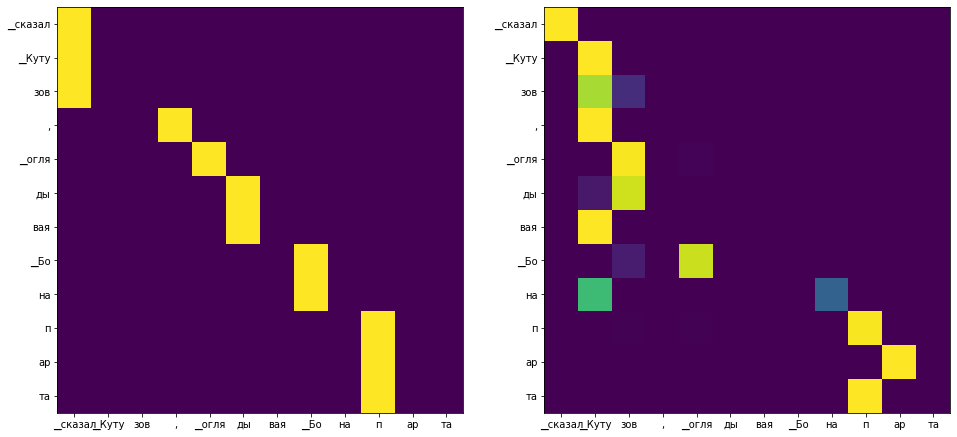

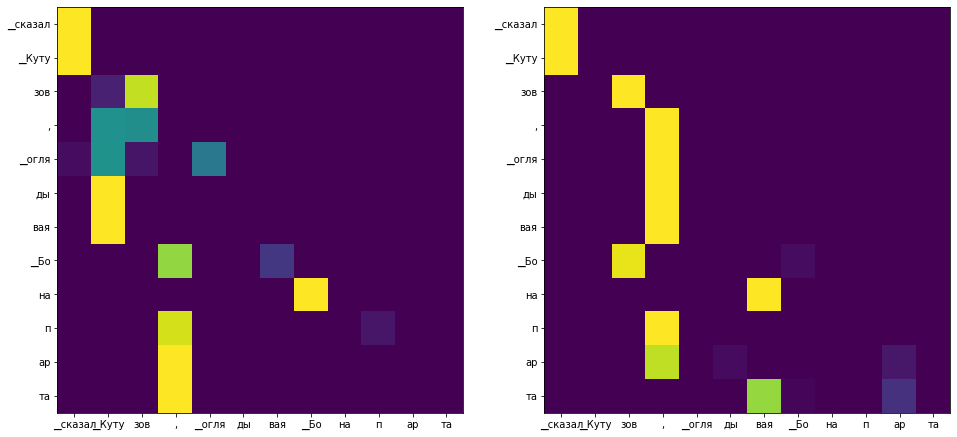

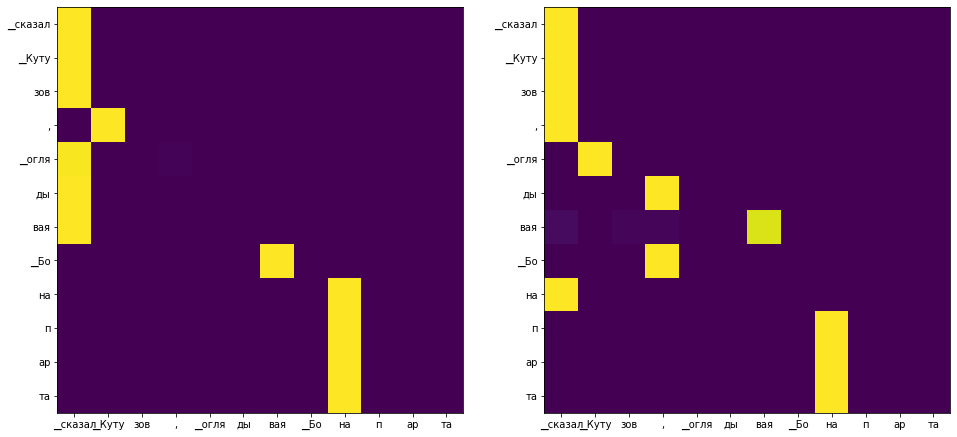

In [49]:
plot_attention_maps(my_transf_model, 'сказал Кутузов, оглядывая Бонапарта', tokenizer)

По строкам **каждого отдельного графика** здесь отложены **запросы**, и каждая позиция помечена токеном во входной последовательности, который стоял на этой позиции. 

По столбцам отложены **ключи**. Чем ярче клетка на пересечении строки и столбца, тем более значим этот ключ для этого запроса (по мнению этой головы этой модели). 

Мы видим, что на первом слое карты активации очень контрастные, очень разреженные. То есть, для каждой выходной позиции близок только один ключ. 

Интересно, что для почти всех N-грамм из имени "Бонапарт", наиболее значимым **ключом** является первая N-грамма этого имени (*четко было на обученной модели, которая самоликвидировалась, а заново 12 часов ждать - ну его. На недоучке похожим образом выделяется токен 'на'*). То есть для вычисления признаков очень важны признаки начала имени ("_бо"). Это и есть **учёт контекста**. 

У второй головы карта активации совершенно другая. Здесь, кажется, в вычислении признаков для всех токенов после запятой (с токена "_огля" и дальше) самый важный исходный токен — это сама "запятая", то есть мы, как бы, отделяем деепричастный оборот здесь. 

Конечно, это всего лишь — попытки натянуть какую-то рационализацию на эти карты активации, неочевидно, что вообще эти карты активации для человека будут понятны или полезны. Но иногда на них просто интересно посмотреть. 

**На втором слое** трансформера карты активации уже более сглаженные, уже нету каких-то отдельных, выделенных, наиболее значимых позиций, уже каждая позиция обращает внимание, в принципе, на все предыдущие позиции. И можно также заметить, что на втором слое верхнетреугольная часть этих карт — тёмная. Это именно то, чего мы хотели добиться, применяя **маску зависимостей**. То есть здесь в маске зависимости на этих позициях стоит $-\infty$.

И никогда не забывать [1]

[1] https://en.wikipedia.org/wiki/No_free_lunch_theorem

Речь идет о теореме "Бесплатного обеда не бывает" -- No Free Lunch Theorem (NFL). Может быть, на русский это лучше перевести, как "бесплатного сыра не бывает". Смысл теоремы в том, что не существует алгоритма (поиска или оптимизации), который "работает" лучше других на всем множестве задач. И если некоторый алгоритм работает лучше (быстрее, точнее) на одних задачах, значит, на других задачах он будет хуже. Если взять весь класс задач, к которому хоть как-то применим конкретный алгоритм, то он в среднем будет не лучше, чем просто случайный поиск. А зачем тогда усложнять?

Интересно, что NFL оказывается тесно связана с [Колмогоровской сложностью](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BC%D0%BE%D0%B3%D0%BE%D1%80%D0%BE%D0%B2%D1%81%D0%BA%D0%B0%D1%8F_%D1%81%D0%BB%D0%BE%D0%B6%D0%BD%D0%BE%D1%81%D1%82%D1%8C). В алгоритмической теории информации колмогоровская сложность объекта (такого, как текст) есть мера вычислительных ресурсов, необходимых для точного определения этого объекта. Также известна как описательная сложность, сложность Колмогорова — Хайтина, стохастическая сложность, алгоритмическая энтропия или алгоритмическая сложность

Cеминар был посвящён сразу нескольким темам — 

- моделированиt языка, 
- byte pair encoding (то есть какая-то токенизация универсальная, современная, которая позволяет выбирать между длиной последовательностей и размером словаря)? использования библиотеки "YouTokenToMe". 
- собрали и обучили языковую модель, используя реализацию трансформера из стандартной библиотеки pytorch, 
- попробовали погенерировать тексты с помощью "полностью жадного" алгоритма и с помощью "лучевого поиска". 
- рассмотрели — как можно руками, самостоятельно, не используя готовой библиотеки, реализовать механизм внимания — используя только базовые операции из pytorch. 
- собрали свой энкодер для трансформера, реализовав механизм внимания с несколькими головами, реализовав "self attention", реализовав отдельный слой трансформера и собрав это всё в encoder. 
- нашу реализацию и увидели, что она, в принципе, работает примерно так же, как и стандартная реализация — значит, кажется, мы не ошиблись. 
- заглянули внутрь обученной модели и посмотрели, как между собой связываются входные и выходные позиции на разных уровнях и для разных голов

# До.за.

Что можно попробовать сделать:

- поиграться с параметрами и архитектурой (количество self-attention модулей, количество голов в MultiHead attention и т.д.)
- рассмотреть разные варианты формул для positional encoding
- менять параметры beam search (beamsize, return_hypotheses_n)